# scANVI
An important task of single-cell analysis is the integration of several samples, which we can perform with scVI. For integration, scVI treats the data as unlabelled. When our dataset is fully labelled (perhaps in independent studies, or independent analysis pipelines), we can obtain an integration that better preserves biology using scANVI, which incorporates cell type annotation information. Here we demonstrate this functionality with an integrated analysis of cells from the lung atlas integration task from the scIB manuscript. The same pipeline would generally be used to analyze any collection of scRNA-seq datasets.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import anndata
from scipy import io

import scanpy as sc
import scvi
import scib
import torch

/opt/conda/envs/sc-py/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/opt/conda/envs/sc-py/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/opt/conda/envs/sc-py/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scvi.settings.seed = 0

Global seed set to 0


In [3]:
adata = sc.read("merged_datasets.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 95097 × 42623
    obs: 'nCount_RNA', 'nFeature_RNA', 'Strain', 'Sex', 'Tissue', 'Technology', 'Author', 'CellType', 'Study', 'Batch', 'DevTP'
    var: 'name'

## Dataset preprocessing
This dataset was already processed as described in the scIB manuscript. Generally, models in scvi-tools expect data that has been filtered/aggregated in the same fashion as one would do with Scanpy/Seurat.

Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate using all genes in terms of runtime, we usually recommend filtering genes for best integration performance. This will, among other things, remove batch-specific variation due to batch-specific gene expression.

We perform this gene selection using the Scanpy pipeline while keeping the full dimension normalized data in the adata.raw object. We obtain variable genes from each dataset and take their intersections.

In [5]:
adata.raw = adata  # keep full dimension safe

In [6]:
sc.pp.log1p(adata)


In [7]:
sc.pp.highly_variable_genes(adata, flavor="seurat", batch_key="Batch", n_top_genes=5000,subset=True)

/opt/conda/envs/sc-py/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/opt/conda/envs/sc-py/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/opt/conda/envs/sc-py/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/opt/conda/envs/sc-py/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append meth

In [8]:
adata

AnnData object with n_obs × n_vars = 95097 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'Strain', 'Sex', 'Tissue', 'Technology', 'Author', 'CellType', 'Study', 'Batch', 'DevTP'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'

## Integration with scVI
As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

Register the AnnData object with the correct key to identify the sample and the layer key with the count data.

Create an SCVI model object.

In [9]:
#adata.raw.X


In [10]:
pip install --upgrade "jax[cpu]"

Note: you may need to restart the kernel to use updated packages.


In [11]:
scvi.model.SCVI.setup_anndata(adata, batch_key="Batch")

/opt/conda/envs/sc-py/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/opt/conda/envs/sc-py/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


We note that these parameters are non-default; however, they have been verified to generally work well in the integration task.

In [12]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb", )

Now we train scVI

In [13]:
torch.set_float32_matmul_precision('high')

In [14]:
vae.train()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 2/84:   1%|▏             | 1/84 [01:10<1:38:08, 70.95s/it, v_num=1, train_loss_step=984, train_loss_epoch=1.06e+3]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 3/84:   2%|▍                 | 2/84 [02:21<1:37:00, 70.98s/it, v_num=1, train_loss_step=962, train_loss_epoch=967]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 4/84:   4%|▋                 | 3/84 [03:32<1:35:42, 70.90s/it, v_num=1, train_loss_step=912, train_loss_epoch=933]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 5/84:   5%|▊                 | 4/84 [04:43<1:34:30, 70.88s/it, v_num=1, train_loss_step=898, train_loss_epoch=912]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 6/84:   6%|█                 | 5/84 [05:54<1:33:20, 70.89s/it, v_num=1, train_loss_step=909, train_loss_epoch=898]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 7/84:   7%|█▎                | 6/84 [07:05<1:32:16, 70.98s/it, v_num=1, train_loss_step=909, train_loss_epoch=889]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 8/84:   8%|█▌                | 7/84 [08:16<1:30:54, 70.84s/it, v_num=1, train_loss_step=906, train_loss_epoch=882]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 9/84:  10%|█▋                | 8/84 [09:26<1:29:35, 70.73s/it, v_num=1, train_loss_step=843, train_loss_epoch=877]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 10/84:  11%|█▊               | 9/84 [10:37<1:28:18, 70.65s/it, v_num=1, train_loss_step=871, train_loss_epoch=873]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 11/84:  12%|█▉              | 10/84 [11:47<1:27:02, 70.57s/it, v_num=1, train_loss_step=866, train_loss_epoch=870]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 12/84:  13%|██              | 11/84 [12:58<1:25:51, 70.57s/it, v_num=1, train_loss_step=854, train_loss_epoch=867]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 13/84:  14%|██▎             | 12/84 [14:08<1:24:39, 70.55s/it, v_num=1, train_loss_step=900, train_loss_epoch=865]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 14/84:  15%|██▍             | 13/84 [15:19<1:23:31, 70.58s/it, v_num=1, train_loss_step=838, train_loss_epoch=864]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 15/84:  17%|██▋             | 14/84 [16:29<1:22:21, 70.60s/it, v_num=1, train_loss_step=838, train_loss_epoch=863]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 16/84:  18%|██▊             | 15/84 [17:40<1:21:16, 70.68s/it, v_num=1, train_loss_step=861, train_loss_epoch=862]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 17/84:  19%|███             | 16/84 [18:51<1:20:11, 70.76s/it, v_num=1, train_loss_step=838, train_loss_epoch=861]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 18/84:  20%|███▏            | 17/84 [20:02<1:18:53, 70.65s/it, v_num=1, train_loss_step=824, train_loss_epoch=860]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 19/84:  21%|███▍            | 18/84 [21:12<1:17:35, 70.54s/it, v_num=1, train_loss_step=841, train_loss_epoch=859]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 20/84:  23%|███▌            | 19/84 [22:22<1:16:22, 70.50s/it, v_num=1, train_loss_step=870, train_loss_epoch=859]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 21/84:  24%|███▊            | 20/84 [23:33<1:15:07, 70.43s/it, v_num=1, train_loss_step=863, train_loss_epoch=858]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 22/84:  25%|████            | 21/84 [24:43<1:13:55, 70.41s/it, v_num=1, train_loss_step=854, train_loss_epoch=858]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 23/84:  26%|████▏           | 22/84 [25:53<1:12:43, 70.38s/it, v_num=1, train_loss_step=865, train_loss_epoch=858]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 24/84:  27%|████▍           | 23/84 [27:04<1:11:36, 70.44s/it, v_num=1, train_loss_step=856, train_loss_epoch=857]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 25/84:  29%|████▌           | 24/84 [28:14<1:10:27, 70.46s/it, v_num=1, train_loss_step=850, train_loss_epoch=857]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 26/84:  30%|████▊           | 25/84 [29:25<1:09:14, 70.41s/it, v_num=1, train_loss_step=841, train_loss_epoch=857]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 27/84:  31%|████▉           | 26/84 [30:35<1:08:01, 70.37s/it, v_num=1, train_loss_step=864, train_loss_epoch=857]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 28/84:  32%|█████▏          | 27/84 [31:45<1:06:46, 70.30s/it, v_num=1, train_loss_step=899, train_loss_epoch=857]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 29/84:  33%|█████▎          | 28/84 [32:55<1:05:38, 70.32s/it, v_num=1, train_loss_step=876, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 30/84:  35%|█████▌          | 29/84 [34:05<1:04:22, 70.23s/it, v_num=1, train_loss_step=839, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 31/84:  36%|█████▋          | 30/84 [35:16<1:03:12, 70.23s/it, v_num=1, train_loss_step=871, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 32/84:  37%|█████▉          | 31/84 [36:26<1:01:59, 70.18s/it, v_num=1, train_loss_step=837, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 33/84:  38%|██████          | 32/84 [37:36<1:00:50, 70.21s/it, v_num=1, train_loss_step=844, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 34/84:  39%|███████           | 33/84 [38:46<59:42, 70.24s/it, v_num=1, train_loss_step=852, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 35/84:  40%|███████▎          | 34/84 [39:56<58:28, 70.17s/it, v_num=1, train_loss_step=845, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 36/84:  42%|███████▌          | 35/84 [41:06<57:16, 70.13s/it, v_num=1, train_loss_step=823, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 37/84:  43%|███████▋          | 36/84 [42:17<56:09, 70.19s/it, v_num=1, train_loss_step=827, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 38/84:  44%|███████▉          | 37/84 [43:27<55:00, 70.23s/it, v_num=1, train_loss_step=871, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 39/84:  45%|████████▏         | 38/84 [44:37<53:51, 70.25s/it, v_num=1, train_loss_step=834, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 40/84:  46%|████████▎         | 39/84 [45:47<52:39, 70.22s/it, v_num=1, train_loss_step=899, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 41/84:  48%|████████▌         | 40/84 [46:57<51:25, 70.13s/it, v_num=1, train_loss_step=892, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 42/84:  49%|████████▊         | 41/84 [48:09<50:28, 70.42s/it, v_num=1, train_loss_step=866, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 43/84:  50%|█████████         | 42/84 [49:19<49:14, 70.35s/it, v_num=1, train_loss_step=848, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 44/84:  51%|█████████▏        | 43/84 [50:29<48:02, 70.30s/it, v_num=1, train_loss_step=886, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 45/84:  52%|█████████▍        | 44/84 [51:39<46:49, 70.23s/it, v_num=1, train_loss_step=825, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 46/84:  54%|█████████▋        | 45/84 [52:49<45:33, 70.08s/it, v_num=1, train_loss_step=874, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 47/84:  55%|█████████▊        | 46/84 [53:59<44:21, 70.04s/it, v_num=1, train_loss_step=879, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 48/84:  56%|██████████        | 47/84 [55:09<43:12, 70.08s/it, v_num=1, train_loss_step=851, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 49/84:  57%|██████████▎       | 48/84 [56:19<41:59, 70.00s/it, v_num=1, train_loss_step=865, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 50/84:  58%|██████████▌       | 49/84 [57:29<40:48, 69.97s/it, v_num=1, train_loss_step=866, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 51/84:  60%|██████████▋       | 50/84 [58:39<39:39, 69.99s/it, v_num=1, train_loss_step=876, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 52/84:  61%|██████████▉       | 51/84 [59:49<38:31, 70.05s/it, v_num=1, train_loss_step=850, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 53/84:  62%|█████████▉      | 52/84 [1:00:59<37:23, 70.11s/it, v_num=1, train_loss_step=866, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 54/84:  63%|██████████      | 53/84 [1:02:09<36:11, 70.04s/it, v_num=1, train_loss_step=866, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 55/84:  64%|██████████▎     | 54/84 [1:03:19<35:00, 70.02s/it, v_num=1, train_loss_step=838, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 56/84:  65%|██████████▍     | 55/84 [1:04:29<33:50, 70.02s/it, v_num=1, train_loss_step=850, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 57/84:  67%|██████████▋     | 56/84 [1:05:39<32:40, 70.03s/it, v_num=1, train_loss_step=839, train_loss_epoch=855]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 58/84:  68%|██████████▊     | 57/84 [1:06:49<31:30, 70.04s/it, v_num=1, train_loss_step=827, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 60/84:  70%|███████████▏    | 59/84 [1:09:09<29:10, 70.03s/it, v_num=1, train_loss_step=876, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 61/84:  71%|███████████▍    | 60/84 [1:10:19<27:58, 69.94s/it, v_num=1, train_loss_step=872, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 62/84:  73%|███████████▌    | 61/84 [1:11:29<26:47, 69.90s/it, v_num=1, train_loss_step=841, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 63/84:  74%|███████████▊    | 62/84 [1:12:38<25:37, 69.89s/it, v_num=1, train_loss_step=835, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 64/84:  75%|████████████    | 63/84 [1:13:48<24:28, 69.91s/it, v_num=1, train_loss_step=873, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 65/84:  76%|████████████▏   | 64/84 [1:14:58<23:19, 69.95s/it, v_num=1, train_loss_step=856, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 66/84:  77%|████████████▍   | 65/84 [1:16:08<22:09, 69.98s/it, v_num=1, train_loss_step=847, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 67/84:  79%|████████████▌   | 66/84 [1:17:19<21:00, 70.01s/it, v_num=1, train_loss_step=853, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 68/84:  80%|████████████▊   | 67/84 [1:18:29<19:53, 70.21s/it, v_num=1, train_loss_step=825, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 69/84:  81%|████████████▉   | 68/84 [1:19:39<18:41, 70.07s/it, v_num=1, train_loss_step=816, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 70/84:  82%|█████████████▏  | 69/84 [1:20:49<17:30, 70.03s/it, v_num=1, train_loss_step=933, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 71/84:  83%|█████████████▎  | 70/84 [1:21:59<16:20, 70.06s/it, v_num=1, train_loss_step=866, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 72/84:  85%|█████████████▌  | 71/84 [1:23:09<15:10, 70.03s/it, v_num=1, train_loss_step=879, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 73/84:  86%|█████████████▋  | 72/84 [1:24:19<13:59, 70.00s/it, v_num=1, train_loss_step=830, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 74/84:  87%|█████████████▉  | 73/84 [1:25:29<12:50, 70.02s/it, v_num=1, train_loss_step=827, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 75/84:  88%|██████████████  | 74/84 [1:26:39<11:39, 69.99s/it, v_num=1, train_loss_step=854, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 76/84:  89%|██████████████▎ | 75/84 [1:27:49<10:29, 69.98s/it, v_num=1, train_loss_step=850, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 77/84:  90%|██████████████▍ | 76/84 [1:28:59<09:19, 69.99s/it, v_num=1, train_loss_step=838, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 78/84:  92%|██████████████▋ | 77/84 [1:30:09<08:09, 69.88s/it, v_num=1, train_loss_step=850, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 79/84:  93%|██████████████▊ | 78/84 [1:31:18<06:59, 69.87s/it, v_num=1, train_loss_step=876, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 80/84:  94%|███████████████ | 79/84 [1:32:28<05:49, 69.86s/it, v_num=1, train_loss_step=891, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 81/84:  95%|███████████████▏| 80/84 [1:33:38<04:39, 69.89s/it, v_num=1, train_loss_step=859, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 82/84:  96%|███████████████▍| 81/84 [1:34:48<03:29, 69.89s/it, v_num=1, train_loss_step=877, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 83/84:  98%|███████████████▌| 82/84 [1:35:58<02:19, 69.97s/it, v_num=1, train_loss_step=856, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 84/84:  99%|███████████████▊| 83/84 [1:37:08<01:09, 69.98s/it, v_num=1, train_loss_step=860, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 84/84: 100%|████████████████| 84/84 [1:38:18<00:00, 69.95s/it, v_num=1, train_loss_step=864, train_loss_epoch=856]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=84` reached.


Epoch 84/84: 100%|████████████████| 84/84 [1:38:18<00:00, 70.22s/it, v_num=1, train_loss_step=864, train_loss_epoch=856]


Once the training is done, we can evaluate the latent representation of each cell in the dataset and add it to the AnnData object

In [15]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

To visualize the scVI’s learned embeddings, we use the pymde package wrapperin scvi-tools. This is an alternative to UMAP that is GPU-accelerated.

In [17]:
from scvi.model.utils import mde
import pymde

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchvision/transforms/_functional_pil.py:242: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  interpolation: int = Image.BILINEAR,
/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchvision/transforms/_functional_pil.py:288: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  interpolation: int = Image.NEAREST,
/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchvision/transforms/_functional_pil.py:304: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  interpolation: int = Image.NEAREST,
/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchvision/transforms/_functional_pil.py:321: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resam

In [18]:
adata.obsm["X_mde"] = mde(adata.obsm["X_scVI"])

In [19]:
adata

AnnData object with n_obs × n_vars = 95097 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'Strain', 'Sex', 'Tissue', 'Technology', 'Author', 'CellType', 'Study', 'Batch', 'DevTP', '_scvi_batch', '_scvi_labels'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scVI', 'X_mde'

/opt/conda/envs/sc-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/opt/conda/envs/sc-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/sc-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


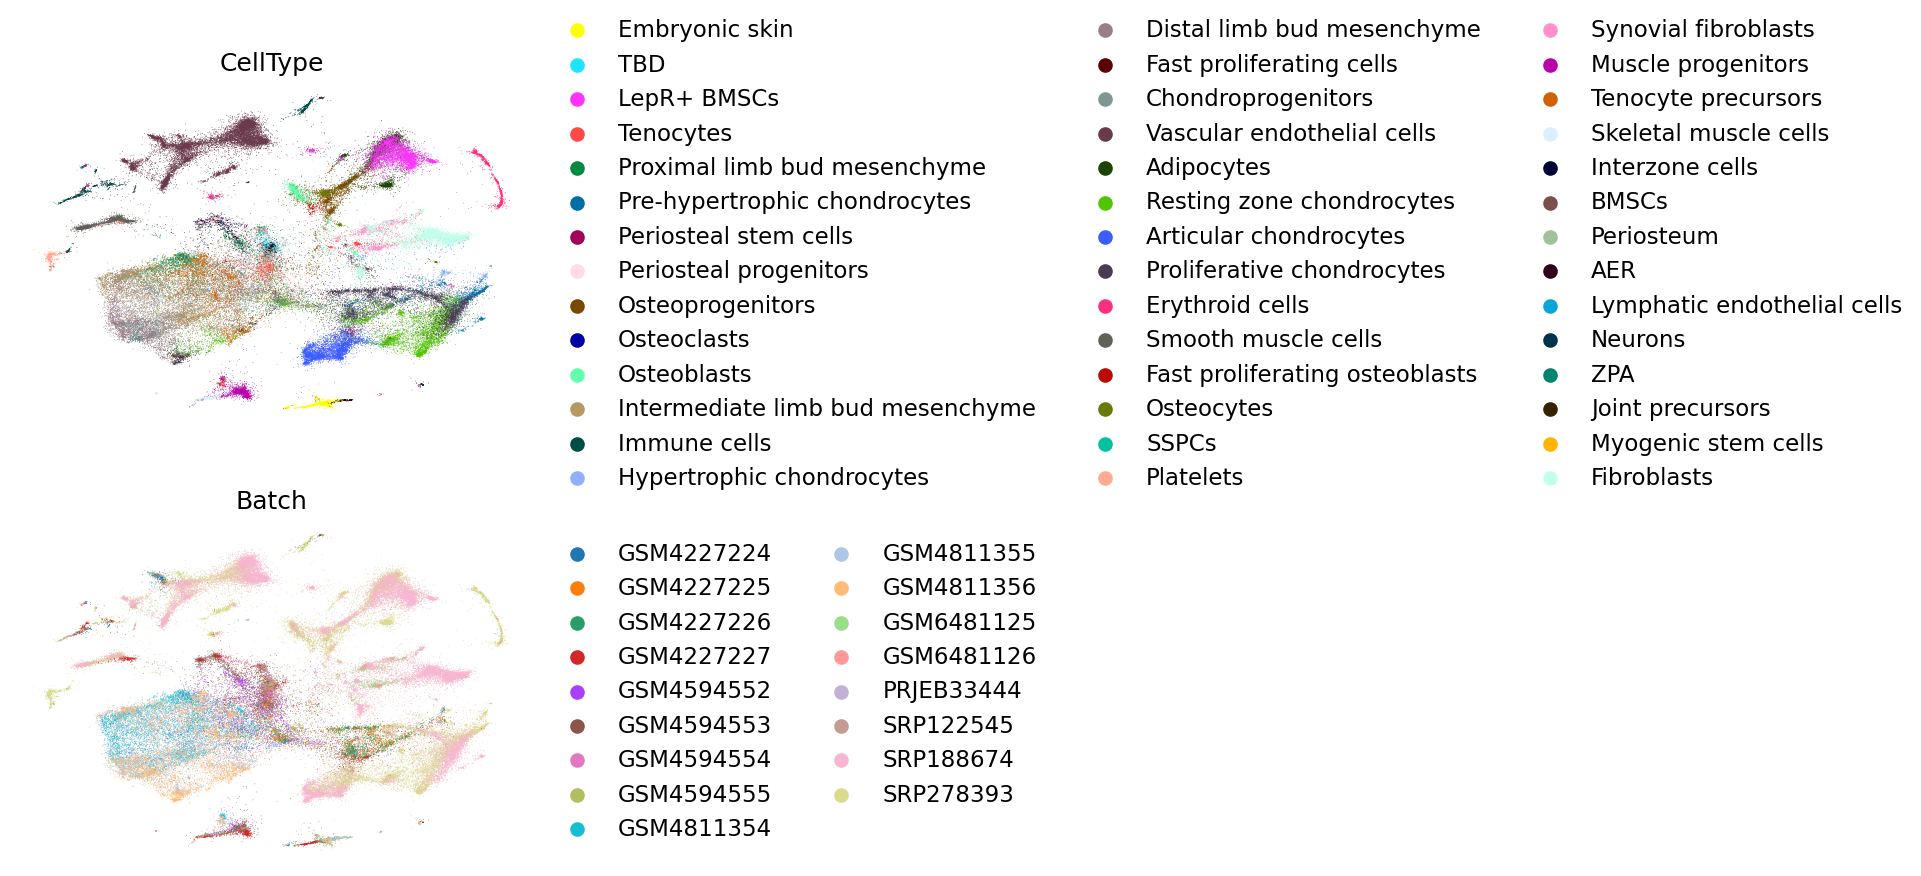

In [21]:
sc.pl.embedding(adata, basis="X_mde", color=["CellType","Batch"], frameon=False, ncols=1)

In [22]:
adata

AnnData object with n_obs × n_vars = 95097 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'Strain', 'Sex', 'Tissue', 'Technology', 'Author', 'CellType', 'Study', 'Batch', 'DevTP', '_scvi_batch', '_scvi_labels'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'CellType_colors', 'Batch_colors'
    obsm: 'X_scVI', 'X_mde'

In [23]:
dir_path = "scVI_model/"
vae.save(dir_path, overwrite=True) 

In [25]:
adata.write("scVI_model/scVI.h5ad")

## Integration with scANVI
Previously, we used scVI as we assumed we did not have any cell type annotations available to guide us. Consequently, after the previous analysis, one would have to annotate clusters using differential expression, or by other means.

Now, we assume that all of our data is annotated. This can lead to a more accurate integration result when using scANVI, i.e., our latent data manifold is better suited to downstream tasks like visualization, trajectory inference, or nearest-neighbor-based tasks. scANVI requires:

the sample identifier for each cell (as in scVI)

the cell type/state for each cell

scANVI can also be used for label transfer and we recommend checking out the other scANVI tutorials to see explore this functionality.

Since we’ve already trained an scVI model on our data, we will use it to initialize scANVI. When initializing scANVI, we provide it the labels_key. As scANVI can also be used for datasets with partially-observed annotations, we need to give it the name of the category that corresponds to unlabeled cells. As we have no unlabeled cells, we can give it any random name that is not the name of an exisiting cell type.

In [26]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="CellType",
    unlabeled_category="TBD",
)

/opt/conda/envs/sc-py/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/opt/conda/envs/sc-py/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [27]:
lvae.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 2/20:   5%|▊               | 1/20 [01:23<26:30, 83.73s/it, v_num=1, train_loss_step=983, train_loss_epoch=1.01e+3]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 3/20:  10%|██                  | 2/20 [02:48<25:16, 84.25s/it, v_num=1, train_loss_step=982, train_loss_epoch=994]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 4/20:  15%|███                 | 3/20 [04:11<23:46, 83.91s/it, v_num=1, train_loss_step=956, train_loss_epoch=991]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 5/20:  20%|████                | 4/20 [05:35<22:21, 83.86s/it, v_num=1, train_loss_step=976, train_loss_epoch=990]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 6/20:  25%|████▊              | 5/20 [06:59<20:58, 83.89s/it, v_num=1, train_loss_step=1e+3, train_loss_epoch=989]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 7/20:  30%|██████              | 6/20 [08:23<19:33, 83.84s/it, v_num=1, train_loss_step=993, train_loss_epoch=988]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 8/20:  35%|███████             | 7/20 [09:47<18:09, 83.83s/it, v_num=1, train_loss_step=992, train_loss_epoch=988]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 9/20:  40%|████████            | 8/20 [11:10<16:45, 83.80s/it, v_num=1, train_loss_step=992, train_loss_epoch=988]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 10/20:  45%|████████▌          | 9/20 [12:34<15:21, 83.80s/it, v_num=1, train_loss_step=974, train_loss_epoch=988]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 11/20:  50%|█████████         | 10/20 [13:58<13:57, 83.76s/it, v_num=1, train_loss_step=991, train_loss_epoch=987]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 12/20:  55%|█████████▉        | 11/20 [15:21<12:33, 83.72s/it, v_num=1, train_loss_step=992, train_loss_epoch=987]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 13/20:  60%|██████████▊       | 12/20 [16:45<11:08, 83.61s/it, v_num=1, train_loss_step=987, train_loss_epoch=987]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 14/20:  65%|███████████▋      | 13/20 [18:08<09:44, 83.53s/it, v_num=1, train_loss_step=964, train_loss_epoch=987]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 15/20:  70%|████████████▌     | 14/20 [19:32<08:21, 83.53s/it, v_num=1, train_loss_step=985, train_loss_epoch=987]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 16/20:  75%|█████████████▌    | 15/20 [20:55<06:57, 83.55s/it, v_num=1, train_loss_step=999, train_loss_epoch=987]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 17/20:  80%|██████████████▍   | 16/20 [22:19<05:34, 83.59s/it, v_num=1, train_loss_step=969, train_loss_epoch=987]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 18/20:  85%|███████████████▎  | 17/20 [23:43<04:10, 83.62s/it, v_num=1, train_loss_step=961, train_loss_epoch=987]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 19/20:  90%|████████████▌ | 18/20 [25:06<02:47, 83.65s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=987]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 20/20:  95%|█████████████████ | 19/20 [26:30<01:23, 83.59s/it, v_num=1, train_loss_step=999, train_loss_epoch=987]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 20/20: 100%|██████████████████| 20/20 [27:53<00:00, 83.51s/it, v_num=1, train_loss_step=963, train_loss_epoch=987]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████████████| 20/20 [27:53<00:00, 83.68s/it, v_num=1, train_loss_step=963, train_loss_epoch=987]


In [28]:
adata

AnnData object with n_obs × n_vars = 95097 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'Strain', 'Sex', 'Tissue', 'Technology', 'Author', 'CellType', 'Study', 'Batch', 'DevTP', '_scvi_batch', '_scvi_labels'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'CellType_colors', 'Batch_colors'
    obsm: 'X_scVI', 'X_mde'

Now we can retrieve the latent space

In [29]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)


In [30]:
adata.obsm["X_mde_scanvi"] = mde(adata.obsm["X_scANVI"])


In [33]:
adata

AnnData object with n_obs × n_vars = 95097 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'Strain', 'Sex', 'Tissue', 'Technology', 'Author', 'CellType', 'Study', 'Batch', 'DevTP', '_scvi_batch', '_scvi_labels'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'CellType_colors', 'Batch_colors', 'Author_colors'
    obsm: 'X_scVI', 'X_mde', 'X_scANVI', 'X_mde_scanvi'

/opt/conda/envs/sc-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/opt/conda/envs/sc-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/sc-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/sc-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


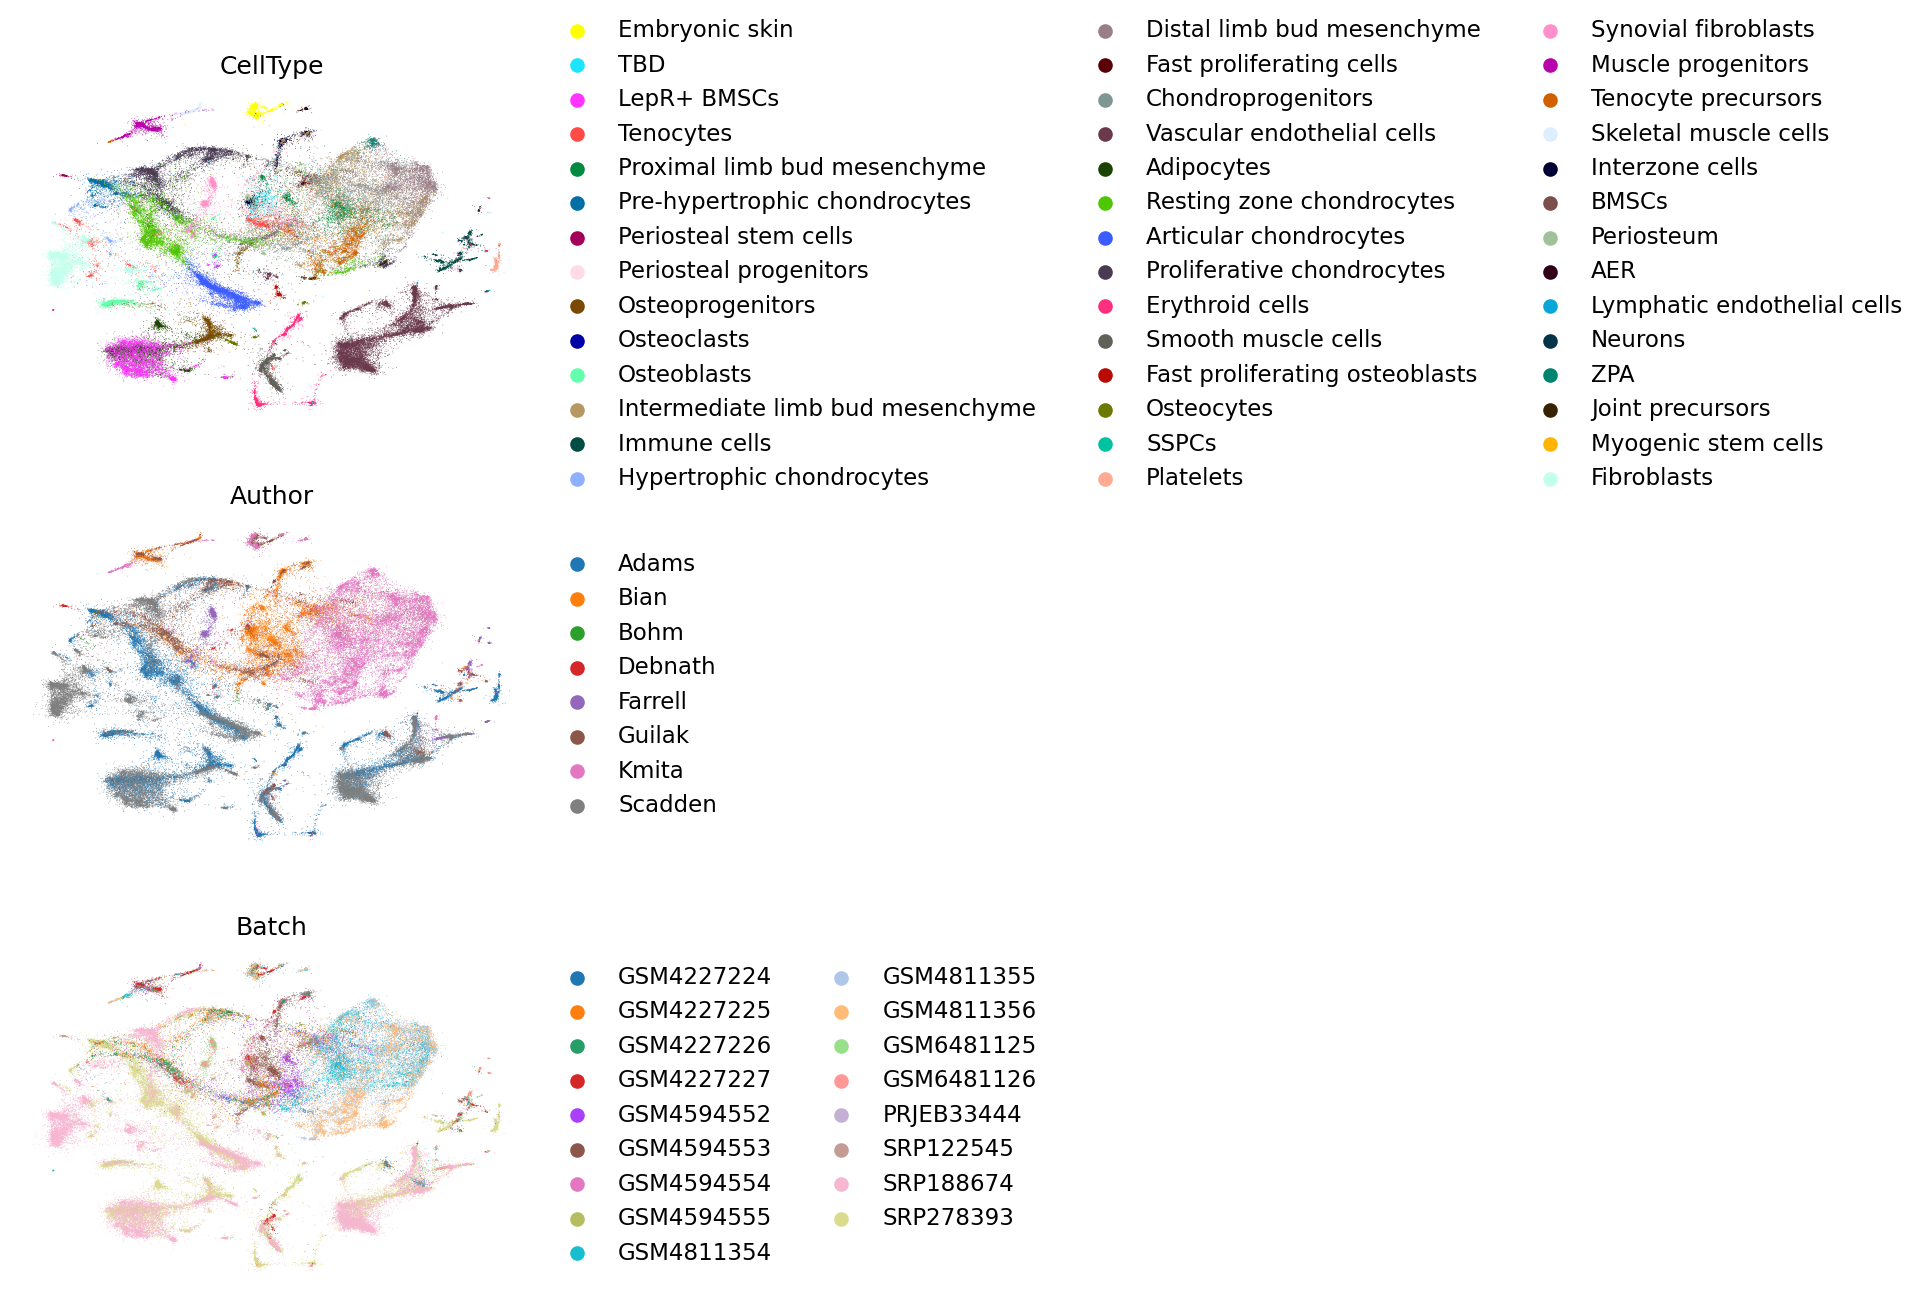

In [35]:
sc.pl.embedding(adata, basis="X_mde_scanvi", color=["CellType","Author","Batch"], ncols=1, frameon=False, )


In [36]:
sc.tl.pca(adata)

In [37]:
dir_path = "./scANVI_model/"
lvae.save(dir_path, overwrite=True) 

In [38]:
adata.write("./scANVI_model/scANVI.h5ad")

In [128]:
adata

AnnData object with n_obs × n_vars = 95097 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'Strain', 'Sex', 'Tissue', 'Technology', 'Author', 'CellType', 'Study', 'Batch', 'DevTP', '_scvi_batch', '_scvi_labels'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'CellType_colors', 'Batch_colors', 'Author_colors', 'pca'
    obsm: 'X_scVI', 'X_scVI_MDE', 'X_scANVI', 'X_scANVI_MDE', 'X_pca'
    varm: 'PCs'